# Create a super smart search engine over any free text data source

This code acompanies the following blog posts by https://medium.com/@thejoshtaylor


In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import nmslib
import time
from google.colab import drive

# drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


    Running setup.py install for nmslib ... done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data and create DF

In [4]:
#LINK TO DATASET USED:
# https://drive.google.com/file/d/13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ/view?usp=sharing

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/export.csv')
df['text'] = df['tendertitle'] + ' ' + df['tenderdescription']+ ' ' + df['locality']+ ' ' + df['postalCode']
df.shape


(212447, 6)

In [ ]:
df.head(1)

,externalid,tendertitle,tenderdescription,locality,postalCode,text
0,00227ecd-50ac-4f92-9e7f-d2675663efa2,TELEPHONY SERVICES,TELEPHONY SERVICES,Exeter,EX1 3PB,TELEPHONY SERVICES TELEPHONY SERVICES Exeter EX1 3PB


### Preprocess and tokenise

In [15]:
def fix_text(x):
  """This function does nothing but leaving
  here as a placeholder for basic text cleaning"""
  return x

nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus
text = df.text.str.lower().values
text = [fix_text(str(i)) for i in text]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text,  disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
212447it [19:50, 178.46it/s]


### Fast text

In [16]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

### Load fasttext and query

In [18]:
ft_model = FastText.load('/content/_fasttext.model')

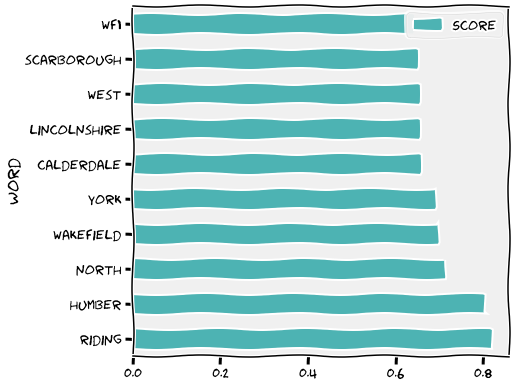

In [19]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("yorkshire", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

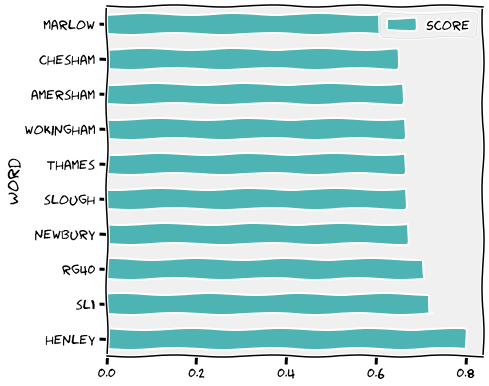

In [20]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("rg9", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

### Creating BM25 document vectors:

In [24]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []

for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    if word is '\x7f':
        continue
    vector = ft_model[word]
    #note for newer versions of fasttext you may need to replace ft_model[word] with ft_model.wv[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
212447it [04:05, 865.88it/s]


In [25]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

### Load document vectors, build index and search:

In [8]:
with open( "weighted_doc_vects.p", "rb" ) as f:
  weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [27]:
# querying the index:
input = 'play'.lower().split()


query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.text.values[i])

Searched 212447 records in 0.0004 seconds 

0.61
WEBSITE GOVERNANCE TOOL SOUTHAMPTON CITY COUNCIL IS CURRENTLY UNDERTAKING A PROCUREMENT ENTITLED "WEBSITE GOVERNANCE TOOL". FOR FULL DETAILS PLEASE REGISTER ON THE SCC ONLINE SOURCING PORTAL WHICH CAN BE ACCESSED HERE HTTPS://SUPPLYSOUTHAMPTON.ESOURCINGPORTAL.COM/ THE PROCUREMENT WILL BE LISTED UNDER CURRENT OPPORTUNITIES. IT IS TITLED "WEBSITE GOVERNANCE TOOL" AND HAS A REFERENCE NUMBER "SCC-GG-744" FOR TECHNICAL ASSISTANCE PLEASE EITHER CONSULT THE CURTIS FITCH SUPPORT SITE (HTTP://WWW.CURTISFITCH.COM/SUPPORT/SUPPLIERS) WHICH CONTAINS USER GUIDES AND TIPS FOR SUBMITTING YOUR QUOTATION, OR THE CURTIS FITCH HELPDESK CAN BE CONTACTED ON 01242 530 900 Southampton SO14 7FP
0.62
DIRECT PAYMENT SUPPORT SERVICE SOUTHAMPTON CITY COUNCIL IS CURRENTLY UNDERTAKING A PROCUREMENT ENTITLED "DIRECT PAYMENT SUPPORT SERVICE". FOR FULL DETAILS PLEASE REGISTER ON THE SCC ONLINE SOURCING PORTAL WHICH CAN BE ACCESSED HERE HTTPS://SUPPLYSOUTHAMPTON.ESOURCING

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [30]:
# querying the index:
input = 'london'.lower().split()


query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.text.values[i])

Searched 212447 records in 0.0004 seconds 

0.42
CPG/2454/2018 PROVISION OF MAINTENANCE SEVICES FOR PROPERTIES IN SOFIA, BULGARIA PRE-PLANNED AND AD-HOC MAINTENANCE SERVICES FOR THE PROPERTIES OWNED OR HIRED BY THE BRITISH EMBASSY SOFIA London SW1A 2AH
0.43
PROVISION OF MAINTENANCE SERVICES FOR PROPERTIES IN SOFIA, BULGARIA PRE-PLANNED AND AD-HOC MAINTENANCE SERVICES FOR THE PROPERTIES OWNED OR HIRED BY THE BRITISH EMBASSY SOFIA London SW1A 2AH
0.44
OUTSOURCING OF PREVENTIVE PERIODIC MAINTENANCE IN THE BRITISH EMBASSY KYIV PRE-PLANNED MAINTENANCE (PPM) AND AD-HOC MAINTENANCE SERVICES FOR ALL THE PROPERTIES OWNED AND RENTED BY THE BRITISH EMBASSY KYIV. London SW1A 2AH
0.45
PROVISION OF WATER TESTING FOR BRITISH EMBASSY MUSCAT THE CONTRACTORS SHALL ARRANGE TO COLLECT SAMPLES FROM ASSIGNED PROPERTIES IN BOTH THE EMBASSY COMPOUNDS AND LEASED PROPERTIES ACCORDING TO AN APPROVED SCHEDULE. London SW1A 2AH
0.45
PROVISION OF WATER TESTING FOR BRITISH EMBASSY MUSCAT THE CONTRACTORS SHALL ARRANGE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [32]:
# querying the index:
input = 'cloud computing'.lower().split()


query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.text.values[i])

Searched 212447 records in 0.0004 seconds 

0.4
PROVISION OF A CLOUD BASED CUSTOMER RELATIONSHIP MANAGEMENT SERVICE PROVISION OF A CLOUD BASED CUSTOMER RELATIONSHIP MANAGEMENT SERVICE
CUSTOMER RELATION MANAGEMENT SOFTWARE PACKAGE
PURCHASED VIA G-CLOUD FRAMEWORK Barnstaple EX31 1DG
0.4
COMMUNICATION CLOUD GOVDELIVERY DIGITAL NOTIFICATIONS SERVICE COMMUNICATION CLOUD GOVDELIVERY DIGITAL NOTIFICATION SERVICE.  G CLOUD 11 SAAS CONTRACT Nottinghamshire NG2 7QP
0.41
DIGITAL CHANNELS PARTNER MINICOMPETITION RUN UNDER GOVERNMENT FRAMEWORK AGREEMENT RM1043-4. EXETER EX13PB
0.41
DIGITAL CHANNELS DELIVERY FURTHER COMPETITION UNDER GOVERNMENT FRAMEWORK AGREEMENT RM1043IV - DOS. EXETER EX13PB
0.41
VIDEO CONFERENCING SUPPORT / MAINTENANCE EXTENSION MINI COMPETITION UTILISING CCS FRAMEWORK RM1058 TECHNOLOGY SERVICES. NOTTINGHAM NG58PP
0.42
CUSTOMER RELATIONSHIP MANAGEMENT SOFTWARE CUSTOMER RELATIONSHIP MANAGEMENT SOFTWARE
PROCURED THROUGH G-CLOUD 10 FRAMEWORK AGREEMENT RM1557.10 Commercial Road EX31 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
